## Calibration for $Z_{Low}$

The aggregate (pc) assets are equal to 22.83
The aggregate assets (Invariant Distribution) are equal to 21.85
The aggregate employment is equal to 0.92
The aggregate (pc) assets are equal to 23.34
The aggregate assets (Invariant Distribution) are equal to 22.60
The aggregate employment is equal to 0.91
The aggregate (pc) assets are equal to 23.44
The aggregate assets (Invariant Distribution) are equal to 22.48
The aggregate employment is equal to 0.91
The aggregate (pc) assets are equal to 23.42
The aggregate assets (Invariant Distribution) are equal to 22.45
The aggregate employment is equal to 0.91


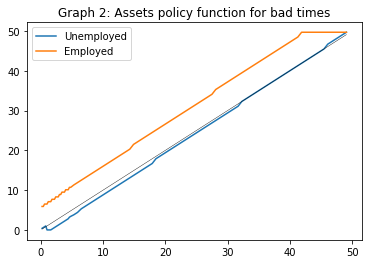

0.9999999999999999

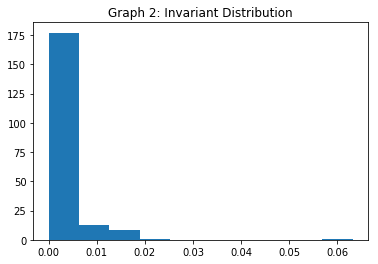

In [4]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
from sympy import *
from sympy.solvers.solveset import linsolve
import itertools as it
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
from scipy.optimize import *
from numpy import *

#Initial guess
L=0.9
K= 17
z=0.95
α=0.36

epsilon=0.001
count1=0
DiffK=1
DiffL=1

while DiffK> epsilon and DiffL > epsilon:
    #Prices
    w=(1-α)*z*pow((K/L),α)
    r=α*z*pow((L/K),(1-α))

    #Parameters
    Γ=0.0025
    γ=8
    β=0.99

    #State space
    e=[0,1]
    k0=np.arange(0,5,0.2)
    k1=np.arange(5.3,50,0.6)
    k=np.concatenate((k0,k1))

    #STEP 1: Computing the utility function for all possible combinations of assets today and tomorrow
    #Retrieving the Consumption Matrix using a non-linear solver
    C=np.empty((100,100,2))
    for i,I,j in it.product(range(100), range(100),range(2)):
        def Implicit(x):
            c=x[0]
            F=empty((1))
            F[0] = pow(w*e[j], (1+γ/γ))*pow(Γ*c, -1/γ) + (1+r)*k[i] - k[I] -c
            return F

        C[i,I,j]=fsolve(Implicit,1)

    #Utility for consumption 
    logC= np.log(C)

    #Checing if there are undefined values for utility in consumption
    np.isnan(logC)
    logC[np.isnan(logC)]=0

    #Computing disutility from labour
    U_L = (Γ/(1+γ))*pow((w/Γ*C), (1+γ)/γ)
    U_L

    #Total Utility 
    U= logC - U_L

    #STEP 2: Initial Guess 
    #Define initial functions 
    #Bad Times
    V0b=np.zeros((100,1))
    V1b=np.zeros((100,1))
    G0b=np.zeros((100,1))
    G1b=np.zeros((100,1))

    #Bad times 
    Π_b= [0.79, 0.21,0.03, 0.97]
    Π_b=np.reshape(Π_b,[2,2])

    #STEP 4: Value Function Iteration
    V0bt=np.zeros((100,1))
    V1bt=np.zeros((100,1))

    count = 0
    eps=0.001
    Devb=0.5
    while Devb > eps: 
        for i in range(99):
            #Bad Times
            V0bt[i]= max(U[i,:,0] + β*((Π_b[0,0]*V0b[i])+ (Π_b[0,1]*V1b[i])))       
            V1bt[i] = max(U[i,:,1] + β*((Π_b[1,0]*V0b[i])+(Π_b[1,1]*V1b[i])))
            G0b[i] = np.argmax(U[i,:,0] + β*((Π_b[0,0]*V0b[i])+ (Π_b[0,1]*V1b[i])))
            G1b[i] = np.argmax(U[i,:,1] + β*((Π_b[1,0]*V0b[i])+(Π_b[1,1]*V1b[i])))

        #Bad times 
        Diff0b=abs(V0bt-V0b)
        dev0b=Diff0b.max()
        Diff1b=abs(V1bt-V1b)
        dev1b=Diff1b.max()

        Devb=max(dev0b, dev1b)
        count+=1

        V0b=V0bt
        V1b=V1bt 

    g0b=np.zeros((100,1))
    g1b=np.zeros((100,1))

    for i in range(100):
        g0b[i]=k[int(G0b[i])]
        g1b[i]=k[int(G1b[i])]    

    #Aggregation. We have 200 different social positions. 
    assets=np.vstack((g0b,g1b))
    A=sum(assets)/200
    print('The aggregate (pc) assets are equal to '"{0:.2f}".format(A))

    #Invariant distribution

    #Step 1: measure over assets
    #Matrix I
    k=np.concatenate((k0,k1))
    grid=np.hstack((k,k))
    I=np.empty((200,200))
    for i in range(200):
        for j in range(200):
            I[i,j]= int(grid[i] ==assets[j])

    #Matrix Pi
    π00=np.ones(100)*0.79
    π01=np.ones(100)*0.21
    π10=np.ones(100)*0.03
    π11=np.ones(100)*0.97

    π0=np.transpose(np.concatenate((π00,π01), axis=0))
    π1=np.transpose(np.concatenate((π10,π11), axis=0))
    π0=np.tile(π0,(100,1))
    π1=np.tile(π1,(100,1))
    π=np.vstack((π0,π1))

    #Matrix T
    T=np.multiply(π,I)

    #Vector M
    M=np.ones((200,1))*(1/200)

    #Get the invariant distribution
    eps=0.001
    diff=1
    count=0
    while diff>eps:
        M=T@M
        diff=(M-M).all()
        count+=1
        M=M

    #Aggregate savings
    S=M*assets
    print('The aggregate assets (Invariant Distribution) are equal to '"{0:.2f}".format(np.sum(S)))

    #Aggregate labour
    S0=S[0:100]
    S1=S[100:200]
    #First, recover the optimal consumption vector
    C1b=np.empty((100,1))
    C0b=np.empty((100,1))
    for i,I in it.product(range(100), range(100)):
        def Ramsey(x):
            c=x[0]
            F=empty((1))
            F[0] = pow(w, (1+γ/γ))*pow(Γ*c, -1/γ) + (1+r)*S1[i] - S1[I] -c
            return F

        C1b[i]=fsolve(Ramsey,1)

    for i,I in it.product(range(100), range(100)):
        def Ramsey(x):
            c=x[0]
            F=empty((1))
            F[0] = (1+r)*S0[i] - S0[I] -c
            return F

        C0b[i]=fsolve(Ramsey,1)

    #Recover the optimal labour vector
    N0b=np.zeros((100,1))
    N1b=np.empty((100,1))
    for j in range(100):
        N1b[j] = pow(((w*e[1])/(Γ*C1b[j])), 1/γ)

    E=np.concatenate((N0b,N1b))

    Employment=M*E
    print('The aggregate employment is equal to '"{0:.2f}".format(np.sum(Employment)))
    
    DiffK=abs(np.sum(S)-K)
    DiffL=abs(np.sum(Employment)-L)
    
    count1+= 1
    
    K=np.sum(S)
    L=np.sum(Employment)

plt.plot(k[1:99],g0b[1:99], label='Unemployed')
plt.plot(k[1:99],g1b[1:99], label='Employed')
plt.plot(k[1:99],k[1:99], 'k', linewidth=0.4)
plt.legend()
plt.title('Graph 2: Assets policy function for bad times')
plt.show() 

plt.hist(M)
plt.title("Graph 2: Invariant Distribution")
np.sum(M)